In [40]:
# READ ME:
# also sometimes the notebook doesn't keep up with updates made to the class file so you have to restart the kernel
# lastly, the TreeDisplay has a method to render a pdf and it can do that from a normal python file if you don't want to use a notebook

In [41]:
from collections import deque
from graphviz import Digraph
from LL1parser import CFG, Lexer
from collections import namedtuple
from nfagen import NFA

In [42]:
Edge = namedtuple('Edge', ['ss', 'fs', 'symbol'])
State = namedtuple('State', ['id', 'type'])

class NfaDisplay:
    def __init__(self, filename=None):
        self.edges = set()
        self.states = set()
        self.start_state = ''
        self.alphabet = []
        self.lam = ''
        if filename != None:
            self.nfa_from_file(filename=filename)
    
    def add_edge(self, startS, endS, char):
        e = Edge(ss=startS, fs=endS, symbol=char)
        self.edges.add(e)
    
    def add_state(self, id, type):
        s = State(id=id, type=type)
        self.states.add(s)

    def read_data(self, fileData):
        # retreive num states, lambda and alphabet from first line
        firstL = fileData[0].split()
        # numStates = firstL[0]
        self.lam = firstL[1]
        for ele in range(2, len(firstL)):
            self.alphabet.append(ele)
        
        for line in fileData[1:]:
            line_list = line.split()
            if len(line_list) > 0:
                stype = line_list[0]
                start_state = line_list[1]
                next_state = line_list[2]
                self.add_state(start_state, stype)

                if start_state == '0': # state 0 is implicitly the start state
                    self.start_state = start_state
                if len(line_list) > 3:
                    for char in line_list[3:]:
                        self.add_edge(start_state, next_state, char)
                else:
                    self.add_edge(start_state, next_state, None)
    
    def nfa_from_file(self, filename):
        with open(filename) as file:
            fileData = file.readlines()
        self.read_data(fileData)

    def nfa_from_string(self, string):
        safeString = string.split('\n')
        self.read_data(safeString)

    def graph_to_dot(self, ld=None):
        dot = Digraph(format='svg')
        dot.attr(rankdir='LR', center='1', ranksep='0.4', nodesep='0.25')
        dot.attr('node', width='.4', fixedsize='true')
        # dot.attr(rankdir='LR')
        # add all the states to the graph
        for state in self.states:
            # node shape depends on node symbol
            match state.type:
                case '+':
                    s = 'doublecircle'
                case '0':
                    s='diamond'
                case _:
                    s='circle'
            dot.node(state.id, shape=s)
        # add edges to the graph
        for e in self.edges:
            if e.symbol is None or e.symbol == '': # if there is no symbol on an edge, don't display it
                continue
            elif e.symbol == ld: # if there is a lambda symbol display it as lambda
                dot.edge(e.ss, e.fs, label='\u03BB')
            else:
                # ascii_val = e.symbol
                ascii_val = e.symbol.lstrip('0x')
                if len(ascii_val) == 1:
                    ascii_val = '0' + ascii_val
                ascii_char = chr(int(ascii_val, 16))
                dot.edge(e.ss, e.fs, ascii_char)
        return dot

    def _repr_svg_(self):
        d = self.graph_to_dot(ld=self.lam)
        result = d.pipe()
        return result.decode('utf-8')

In [43]:
class TreeDisplay():
    def __init__(self, rootNode):
        self.rootNode = rootNode
    
    def graph_to_dot(self, rootNode):
        dot = Digraph(format='svg')
        dot.attr('node', shape='oval')

        worklist = deque()
        worklist.append(rootNode)
        processed = set()
        while worklist:
            node = worklist.popleft()
            nodeLabel = node.value if node.kind == 'char' else node.kind
            dot.node(str(id(node)), nodeLabel)

            for child in node.children:
                if child not in processed:
                    childLabel = child.value if child.kind == 'char' else child.kind
                    dot.node(str(id(child)), childLabel)
                    dot.edge(str(id(node)), str(id(child)))
                    worklist.append(child)
                    processed.add(child)
        return dot
    
    def render_pdf(self, filename=None):
        d = self.graph_to_dot(self.rootNode)
        if filename is None:
            d.render(cleanup=True, format='pdf', directory='tree-images')
        else:
            d.render(filename=filename, cleanup=True, format='pdf', directory='tree-images')

    def _repr_svg_(self):
        d = self.graph_to_dot(self.rootNode)
        result = d.pipe()
        return result.decode('utf-8')

In [44]:
cfg = CFG()
filename = 'llre.cfg'
try:
    with open(filename) as file:
        for line in file:
            cfg.add_production_rule(line.strip())
except FileNotFoundError:
    print(f"File '{filename}' not found, check your input")

cfg.generate_llt()

l = Lexer()
ts = l.lex('a-b.q')

tree = cfg.parse(ts)

alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'q']
nfa = NFA(alphabet)
nfa.lambda_wrap(0, 1, tree)
# print(nfa.T)
# print(nfa.L)
# print(nfa)

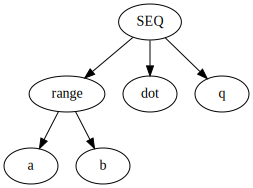

In [45]:
td = TreeDisplay(tree)
td

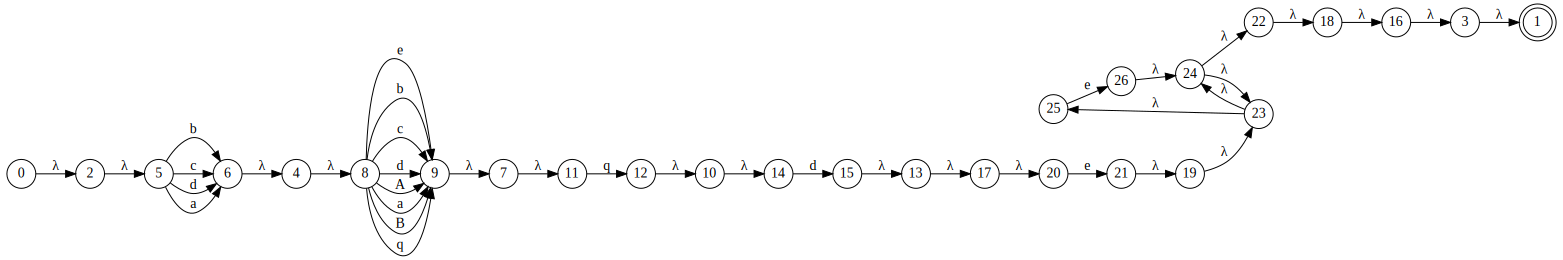

In [46]:
# print(nfa)
nd = NfaDisplay()
nd.nfa_from_file('../testNFAoutput.txt')
# nd.nfa_from_string(str(nfa))
nd